In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
from pmdarima.arima import ADFTest, KPSSTest, ndiffs, auto_arima
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
import scipy.stats as stats
from scipy import signal
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from loess import loess_1d
import yfinance as yf

### Analyzing time series for the term premium of 10Y and 3M Treasury yields, SPX500 returns and US CPI

In [3]:

# Download S&P 500 data (you can modify the ticker symbol as needed)
spx = yf.download('^GSPC', start='2000-01-01', end='2024-12-31')

# Calculate daily returns (yield)
spx['Daily Return'] = spx['Close'].pct_change()

# Drop the first row as it will have a NaN value for the return
spx = spx.dropna()

# Show the first few rows with the calculated daily returns
print(spx[['Close', 'Daily Return']].head())
spx.columns = spx.columns.droplevel(1)

# Reset index if needed
spx.reset_index(inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price             Close Daily Return
Ticker            ^GSPC             
Date                                
2000-01-04  1399.420044    -0.038345
2000-01-05  1402.109985     0.001922
2000-01-06  1403.449951     0.000956
2000-01-07  1441.469971     0.027090
2000-01-10  1457.599976     0.011190


In [4]:
#read data
cpi = pd.read_csv('data/CPI_US_YOY.csv')
m3_yield = pd.read_csv('data/US_3M_YIELD.csv')
y10_yield = pd.read_csv('data/US_10Y_YIELD.csv')

In [5]:

spx

Price,Date,Close,High,Low,Open,Volume,Daily Return
0,2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000,-0.038345
1,2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000,0.001922
2,2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000,0.000956
3,2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000,0.027090
4,2000-01-10,1457.599976,1464.359985,1441.469971,1441.469971,1064800000,0.011190
...,...,...,...,...,...,...,...
6282,2024-12-23,5974.069824,5978.250000,5902.569824,5940.250000,3593280000,0.007287
6283,2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000,0.011043
6284,2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2904530000,-0.000406
6285,2024-12-27,5970.839844,6006.169922,5932.950195,6006.169922,3159610000,-0.011056


In [6]:
#prepare SPX data and calculate daily returns
spx = spx[['Date', 'Close']]
#spx = spx.reset_index()  # Ensure 'Date' is a column
spx.columns = ['Date', 'spx']  # Rename the columns
spx['spx_returns'] = spx['spx'].pct_change()

C:\Users\Dell\AppData\Local\Temp\ipykernel_16168\173747210.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spx['spx_returns'] = spx['spx'].pct_change()


In [7]:
#clean and preprocess data
#gdp.rename(columns={"MABMM301USM189S": "gdp"}, inplace=True)
cpi.rename(columns={"CPIAUCSL_PC1": "cpi"}, inplace=True)
m3_yield.rename(columns={'DGS3MO':'m3'},inplace = True)
y10_yield.rename(columns={'DGS10':'y10'},inplace = True)



In [8]:
def reindex_df(df):
    """ Adding DateTime index to df"""
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.rename(columns={df.columns[0]: "date"}, inplace=True)
        df.set_index("date", inplace=True)
        df.index = pd.to_datetime(df.index)
    return df

def reindex_daily(df):
    """reindex daily frequencies and fill missing values (mostly weekends)"""
    df = df.copy()
    df = reindex_df(df)

    start_date = '2010-01-01'
    end_date = '2024-12-31'
    
    # Fill weekends and missing dates
    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    df = df.reindex(full_range).ffill().bfill()

    return df

def reindex_monthly(df):
    """reindex monthly frequencies to daily and fill missing values"""
    df = df.copy()
    df = reindex_df(df)

    start_date = df.index.min() - pd.DateOffset(days=1)
    end_date = df.index.max() + pd.DateOffset(days=31)
    
    full_range = pd.date_range(start='2010-01-01', end='2024-12-31', freq="D")
    df = df.reindex(full_range).ffill().bfill()

    return df

In [9]:
#reindex and forward fill
#gdp_daily = reindex_monthly(gdp)
cpi_daily = reindex_monthly(cpi)
spx = reindex_daily(spx)
t3m = reindex_daily(m3_yield)
t10y = reindex_daily(y10_yield)




In [10]:
data = pd.concat([cpi_daily, spx], axis=1, join='outer')
data['term_premium'] = t10y['y10']-t3m['m3']
data['spx_log_returns'] = np.log(1 + data['spx_returns'])
data['term_premium_log_change'] = np.log(1 + data['term_premium'].pct_change())
data = data.reindex(pd.date_range(start='2010-01-02', end='2024-12-31', freq="D"))

C:\Users\Dell\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Dell\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
data

,cpi,spx,spx_returns,term_premium,spx_log_returns,term_premium_log_change
2010-01-02,2.62111,1132.989990,0.016043,3.77,0.015916,0.000000
2010-01-03,2.62111,1132.989990,0.016043,3.77,0.015916,0.000000
2010-01-04,2.62111,1132.989990,0.016043,3.77,0.015916,0.000000
2010-01-05,2.62111,1136.520020,0.003116,3.70,0.003111,-0.018742
2010-01-06,2.62111,1137.140015,0.000546,3.79,0.000545,0.024033
...,...,...,...,...,...,...
2024-12-27,2.87237,5970.839844,-0.011056,0.31,-0.011117,0.298493
2024-12-28,2.87237,5970.839844,-0.011056,0.31,-0.011117,0.000000
2024-12-29,2.87237,5970.839844,-0.011056,0.31,-0.011117,0.000000
2024-12-30,2.87237,5906.939941,-0.010702,0.18,-0.010760,-0.543615


In [12]:
log_returns = data['spx_log_returns'].copy()

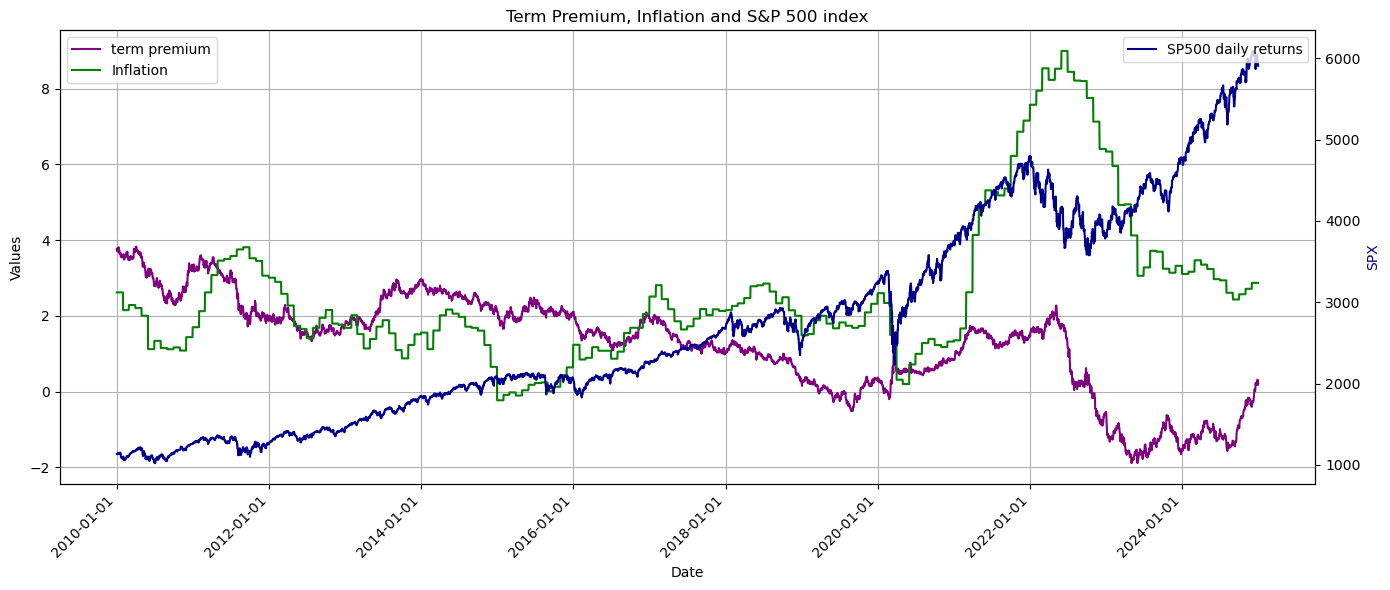

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 6))

# Create the primary axis (left side) for the main data
ax1 = fig.add_subplot(111)


ax1.plot(data.index, data['term_premium'], label="term premium", color='purple')
ax1.plot(data.index, data["cpi"], label="Inflation", color="g")

# Set the left axis labels
ax1.set_xlabel('Date')
ax1.set_ylabel('Values', color='black')

# Make the dates on the x-axis more readable (rotate and format)
plt.xticks(rotation=45, ha='right')
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

# Create the secondary axis (right side) for the S&P500 data
ax2 = ax1.twinx()
ax2.plot(data.index, data["spx"], label="SP500 daily returns", color="darkblue")

# Set the right axis labels
ax2.set_ylabel('SPX', color='darkblue')

# Add legends for both axes
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Title for the plot
plt.title("Term Premium, Inflation and S&P 500 index")

# Show gridlines
ax1.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 's&p 500 log returns')

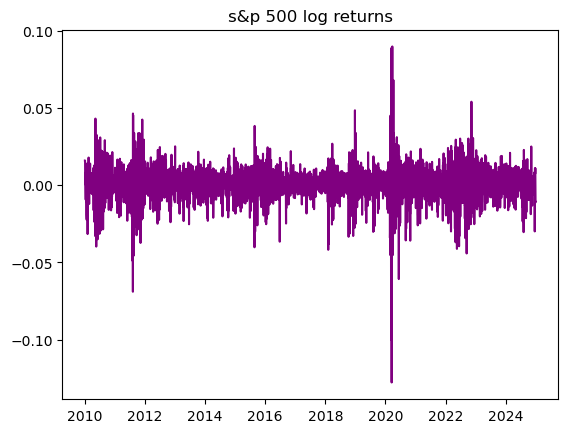

In [14]:
plt.plot(data.index, log_returns, label="s&p 500 returns", color='purple')
plt.title('s&p 500 log returns')

Text(0.5, 1.0, 'Term Premium daily log change')

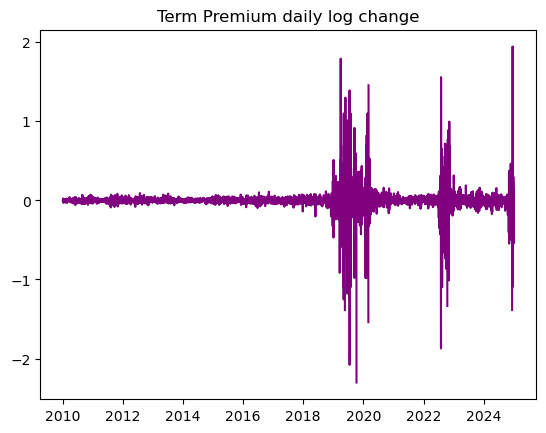

In [15]:
plt.plot(data.index, data['term_premium_log_change'], label="term premium", color='purple')
plt.title("Term Premium daily log change")

## 1.1 Dependence Analysis with Copulas
Based on the fitted empirical copulas, the strongest relationship is observed between the S&P 500 and the Term Premium.

For autocopulas fitted on the first lag, the S&P 500 time series shows the strongest dependence on past values, as the point dispersion is smaller compared to the Term Premium variable.

As the number of lags increases, focal points appear in the autocopula of the S&P 500. That is, it remains narrow in some regions and widens in others, which may indicate that the strength of the relationship with past values increases periodically. This makes sense, since the copula is based on S&P 500 prices, not returns—larger focal points may correspond to low-return, stagnant years when prices changed less, leading to stronger dependence. In the case of returns, the relationship with the past is very weak, as the copula covers the entire area.

While the Term Premium’s autocopula remains relatively consistent over monthly and semiannual horizons, it significantly widens at the one-year horizon.

For inflation, the relationship still appears strong at a one-month lag, which is understandable given the lower fluctuations in monthly data. However, at a one-year lag, the inflation copula also widens, indicating a weaker relationship with past values. Still, at very high values, the copula remains dense even at the one-year lag, which may reflect the persistence of high-inflation periods.

In [17]:
from scipy.stats import rankdata, uniform, gamma, t, pearsonr, norm
from scipy.stats import t, multivariate_normal
from scipy.integrate import dblquad
from copulas.univariate import GaussianKDE
from copulas.univariate import GammaUnivariate
from copulas.multivariate import GaussianMultivariate
from scipy.stats import rankdata

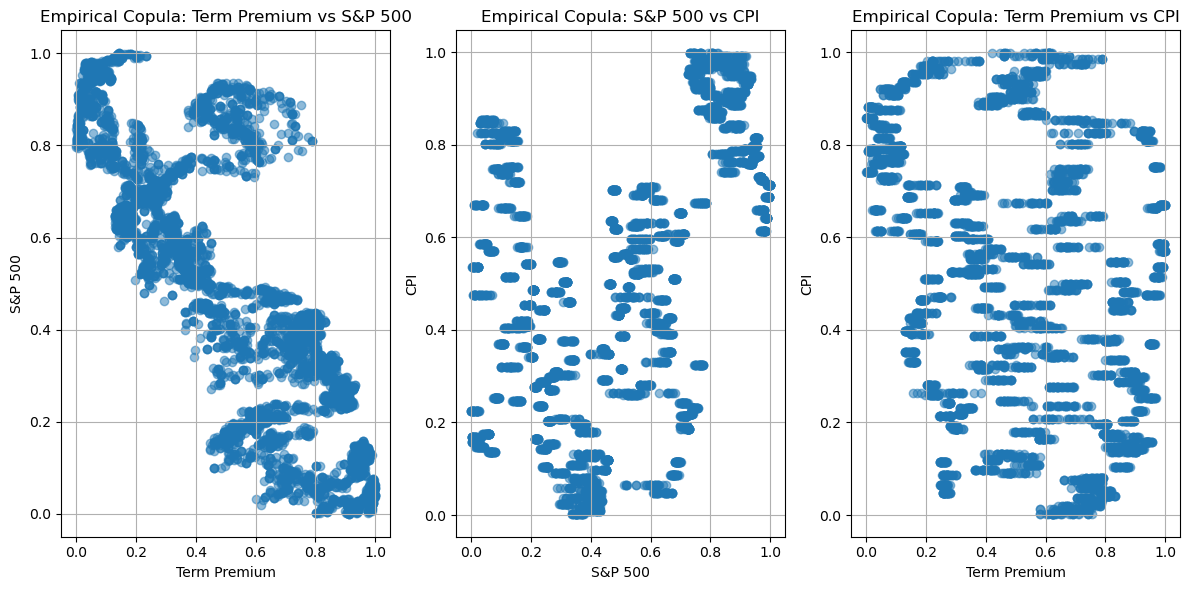

In [18]:
#Empirical copulas

u_term_premium = rankdata(data['term_premium']) / len(data['term_premium'])
u_spx_500 = rankdata(data['spx']) / len(data['spx'])
u_cpi = rankdata(data['cpi']) / len(data['cpi'])

# Combine data into a matrix of uniform marginals (copula space)
copula_data = np.column_stack((u_term_premium, u_spx_500, u_cpi))

# Plot the empirical copula for all pairs of variables
plt.figure(figsize=(12, 6))

# Plot the pairwise copulas
plt.subplot(1, 3, 1)
plt.scatter(u_term_premium, u_spx_500, alpha=0.5)
plt.title('Empirical Copula: Term Premium vs S&P 500')
plt.xlabel('Term Premium')
plt.ylabel('S&P 500')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.scatter(u_spx_500, u_cpi, alpha=0.5)
plt.title('Empirical Copula: S&P 500 vs CPI')
plt.xlabel('S&P 500')
plt.ylabel('CPI')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.scatter(u_term_premium, u_cpi, alpha=0.5)
plt.title('Empirical Copula: Term Premium vs CPI')
plt.xlabel('Term Premium')
plt.ylabel('CPI')
plt.grid(True)

plt.tight_layout()
plt.show()

lag = 1


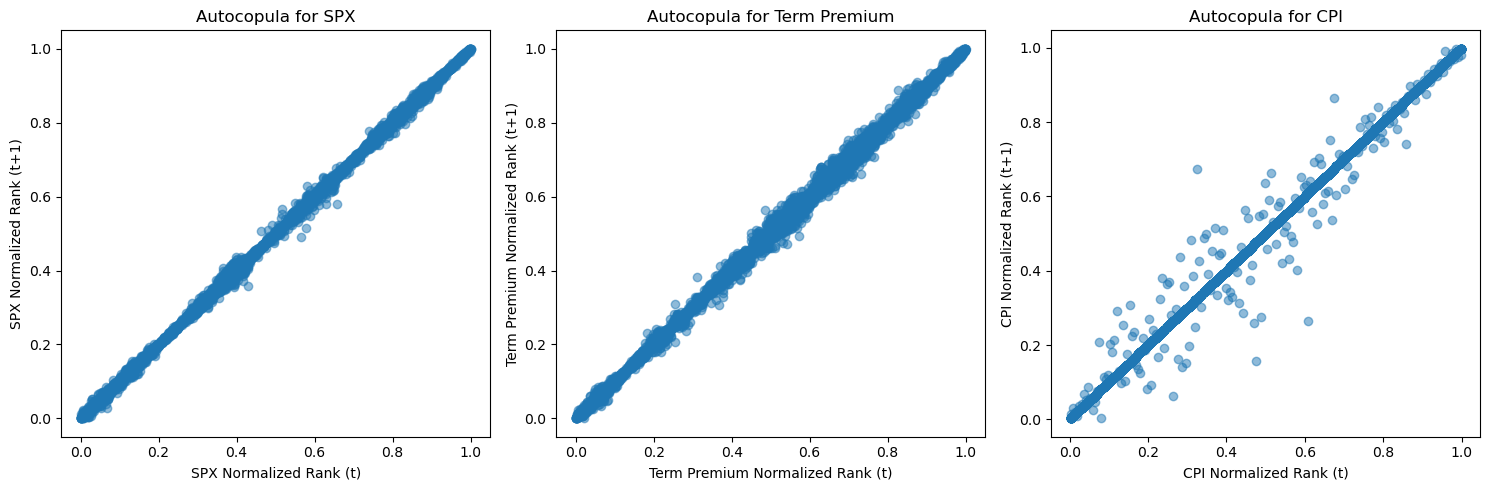

lag = 7


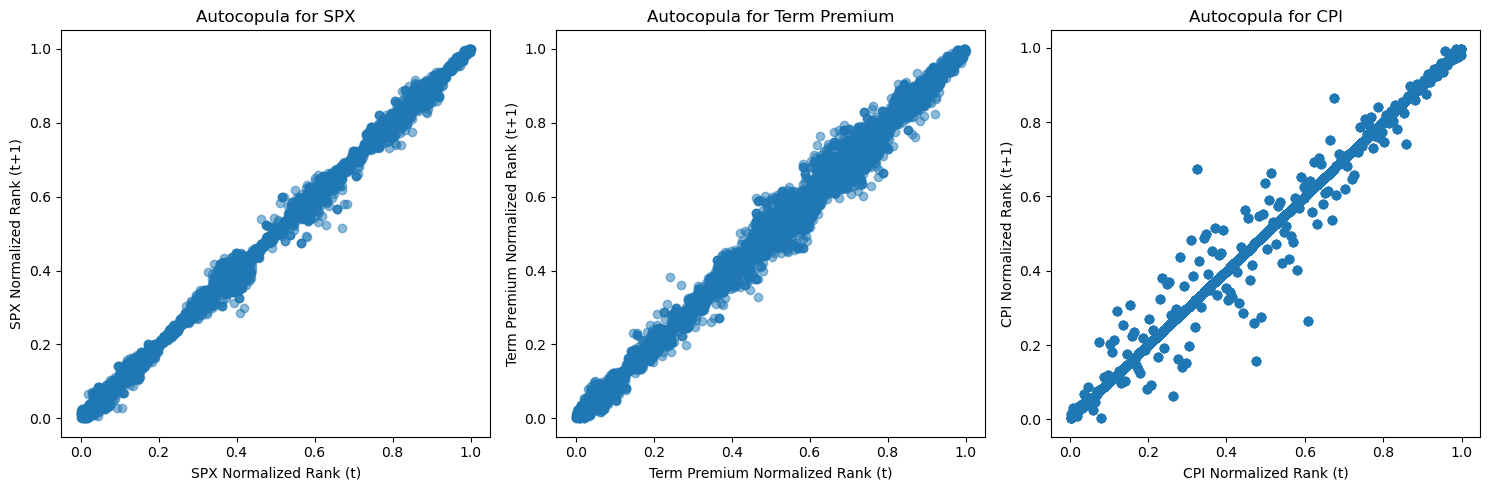

lag = 30


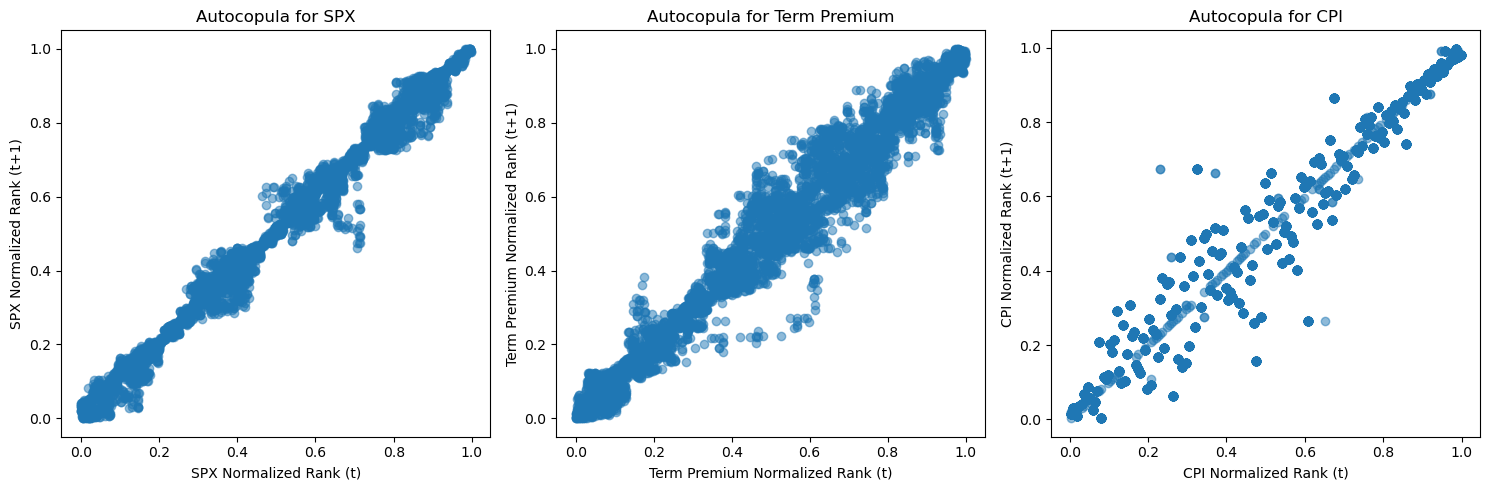

lag = 180


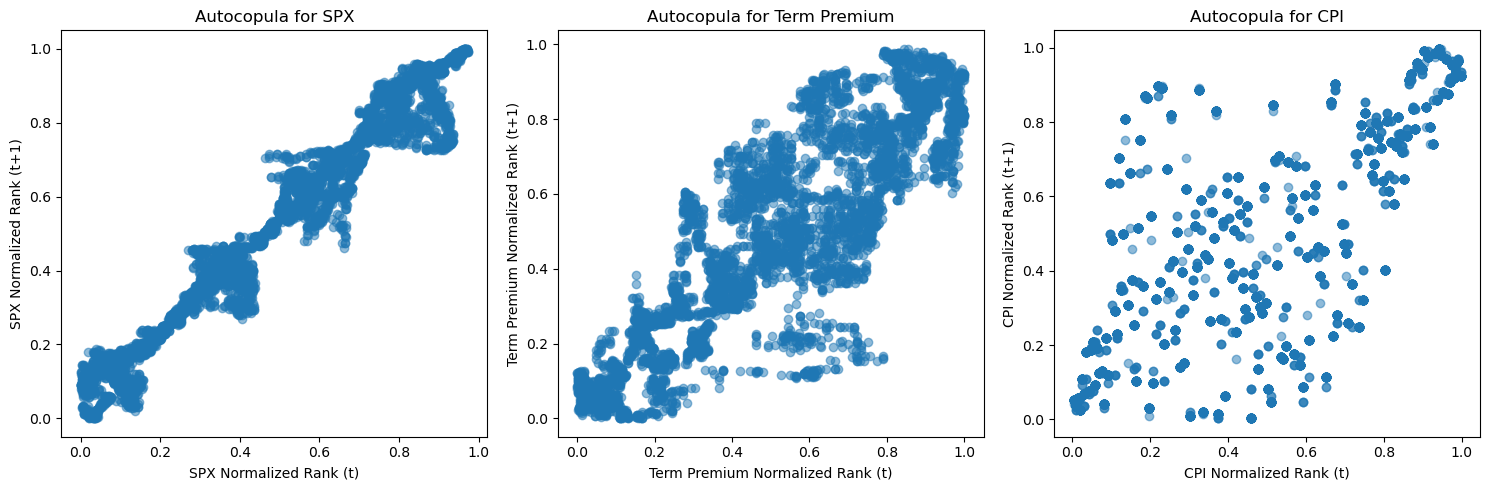

lag = 365


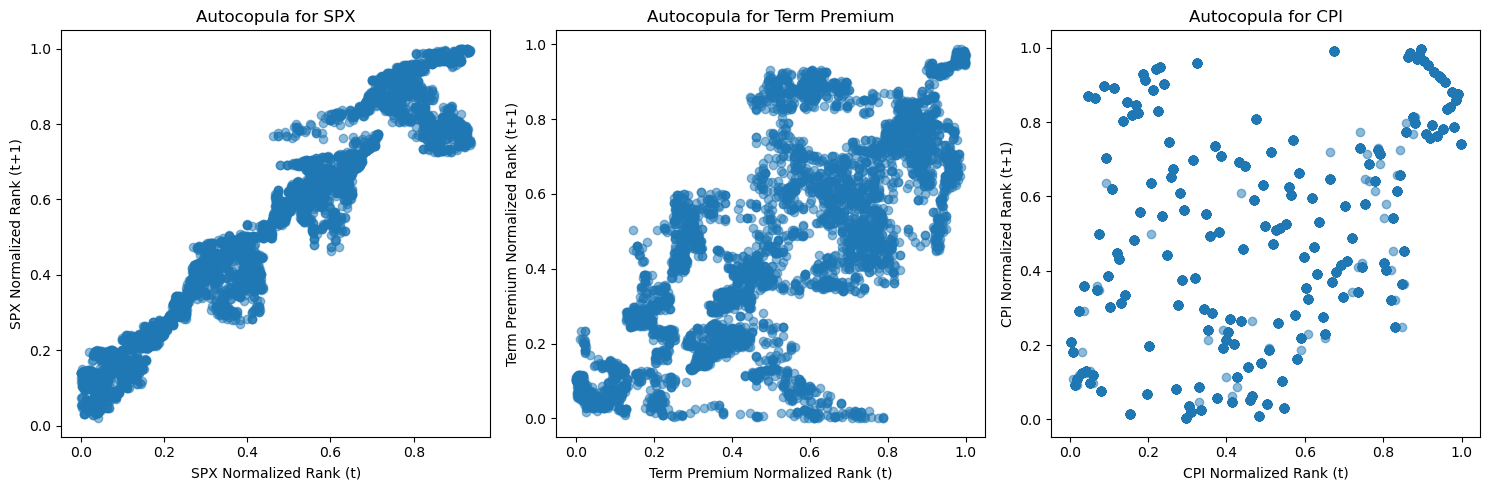

In [19]:
# Rank the data (empirical copula requires ranks)



def create_autocopula_points(series_normalized, lag=1):
    """Create autocopula points by pairing the normalized ranks with their lagged versions."""
    series_lagged = np.roll(series_normalized, shift=lag)
    return np.column_stack((series_normalized[:-lag], series_normalized[lag:]))


def fit_visualize_autocopula(lag):
    print(f'lag = {lag}')
    # Compute empirical autocopulas
    autocopula_spx = create_autocopula_points(u_spx_500, lag)
    autocopula_term_premium = create_autocopula_points(u_term_premium, lag)
    autocopula_cpi = create_autocopula_points(u_cpi, lag)
    
    
    # Visualize the autocopula points as scatter plots
    plt.figure(figsize=(15, 5))
    
    # SPX autocopula
    plt.subplot(1, 3, 1)
    plt.scatter(autocopula_spx[:, 0], autocopula_spx[:, 1], alpha=0.5)
    plt.title('Autocopula for SPX')
    plt.xlabel('SPX Normalized Rank (t)')
    plt.ylabel('SPX Normalized Rank (t+1)')
    
    # Term Premium autocopula
    plt.subplot(1, 3, 2)
    plt.scatter(autocopula_term_premium[:, 0], autocopula_term_premium[:, 1], alpha=0.5)
    plt.title('Autocopula for Term Premium')
    plt.xlabel('Term Premium Normalized Rank (t)')
    plt.ylabel('Term Premium Normalized Rank (t+1)')
    
    # CPI autocopula
    plt.subplot(1, 3, 3)
    plt.scatter(autocopula_cpi[:, 0], autocopula_cpi[:, 1], alpha=0.5)
    plt.title('Autocopula for CPI')
    plt.xlabel('CPI Normalized Rank (t)')
    plt.ylabel('CPI Normalized Rank (t+1)')
    
    plt.tight_layout()
    plt.show()

fit_visualize_autocopula(1)
fit_visualize_autocopula(7)
fit_visualize_autocopula(30)
fit_visualize_autocopula(180)
fit_visualize_autocopula(365)

## 1.2 Egy idősor teljeskörű elemzése

### 1.2.1 Examination of Periodicity

- **FFT transformation:**
    - the amplitude can help identify cycles
    - the phase spectrum is usually less significant in financial time series

- Weak autocorrelation can be observed in the log returns and in the differences as well, with the first term being significant
- **Decomposition**:
   - The residual component shows a more significant spike in 2020, most likely due to the uncertainties and turbulence caused by COVID
   - A seasonal component also emerges, repeating annuallylódik, évente ismétlődik

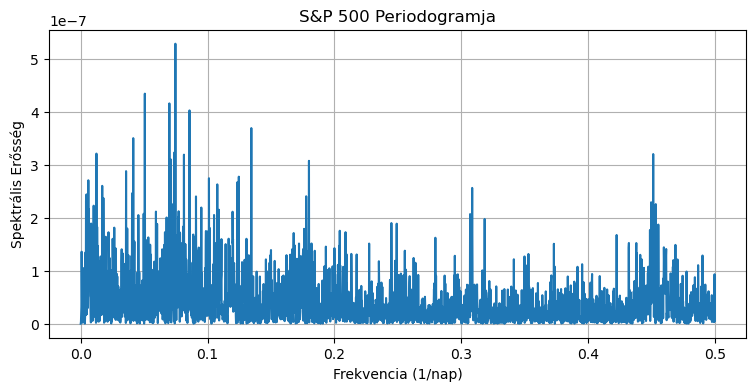

In [22]:
f, Pxx_spec = signal.periodogram(log_returns, fs=1, scaling='spectrum')

plt.figure(figsize=(9, 4))
plt.plot(f, Pxx_spec)
plt.title('S&P 500 Periodogramja')
plt.xlabel('Frekvencia (1/nap)')
plt.ylabel('Spektrális Erősség')
plt.grid(True)
plt.show()



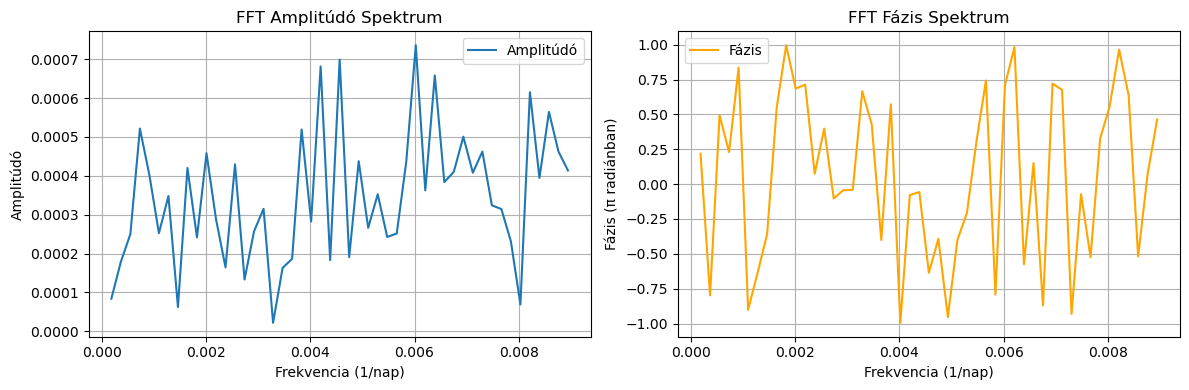

In [23]:

# Autokorrelációs függvény
acfasn = sm.tsa.acf(log_returns, nlags=len(spx)//2, fft=True)

# FFT végzése a napfolt-adatokon
Y      = np.fft.fft(log_returns)
freq   = np.fft.fftfreq(len(log_returns), d=1)
amplit = np.abs(Y) / (len(log_returns) / 2)  # amplitúdó skálázás
phase  = np.angle(Y)
phase  = phase / np.pi  # fázist pi radiánban fejezzük ki

# Ábrázolás (csak a kis frekvenciás tartományra)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(freq[1:50], amplit[1:50], label='Amplitúdó')
ax[1].plot(freq[1:50], phase[1:50], label='Fázis', color='orange')
ax[0].set_title('FFT Amplitúdó Spektrum')
ax[1].set_title('FFT Fázis Spektrum')
ax[0].set_xlabel('Frekvencia (1/nap)')
ax[1].set_xlabel('Frekvencia (1/nap)')
ax[0].set_ylabel('Amplitúdó')
ax[1].set_ylabel('Fázis (π radiánban)')
ax[0].grid(True)
ax[1].grid(True)
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

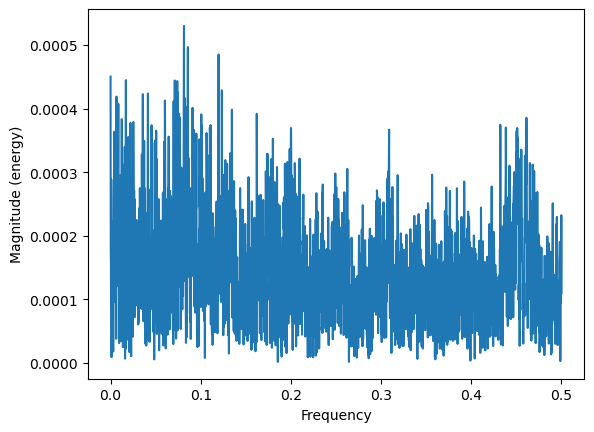

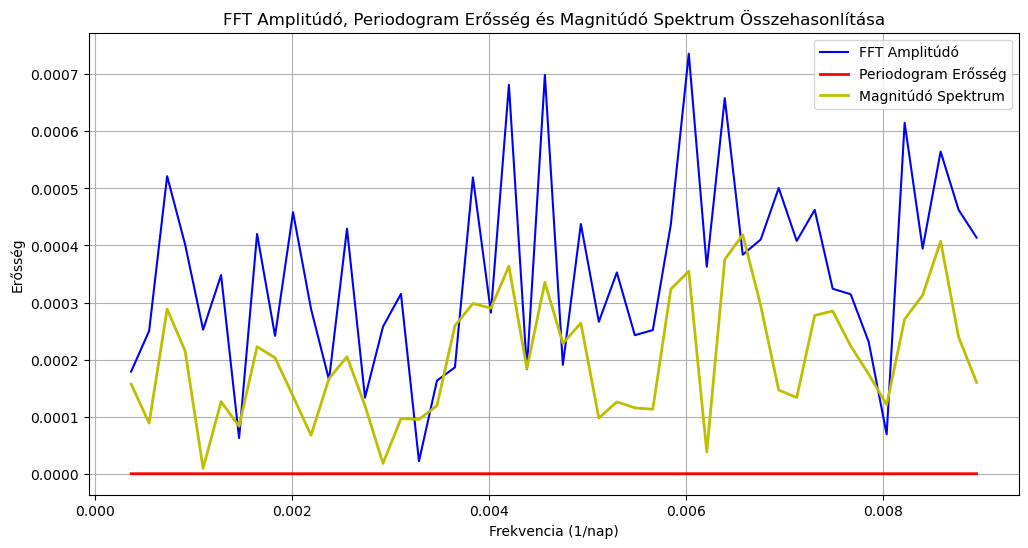

In [24]:
specsn = plt.magnitude_spectrum(log_returns, Fs=1, window=None)

plt.figure(figsize=(12, 6))
plt.plot(freq[2:50], amplit[2:50], 'b', label='FFT Amplitúdó')
plt.plot(freq[2:50], Pxx_spec[2:50]/58, 'r', label='Periodogram Erősség', linewidth=2)
plt.plot(freq[2:50], specsn[0][2:50], 'y', label='Magnitúdó Spektrum', linewidth=2)
plt.title('FFT Amplitúdó, Periodogram Erősség és Magnitúdó Spektrum Összehasonlítása')
plt.xlabel('Frekvencia (1/nap)')
plt.ylabel('Erősség')
plt.grid(True)
plt.legend()
plt.show()

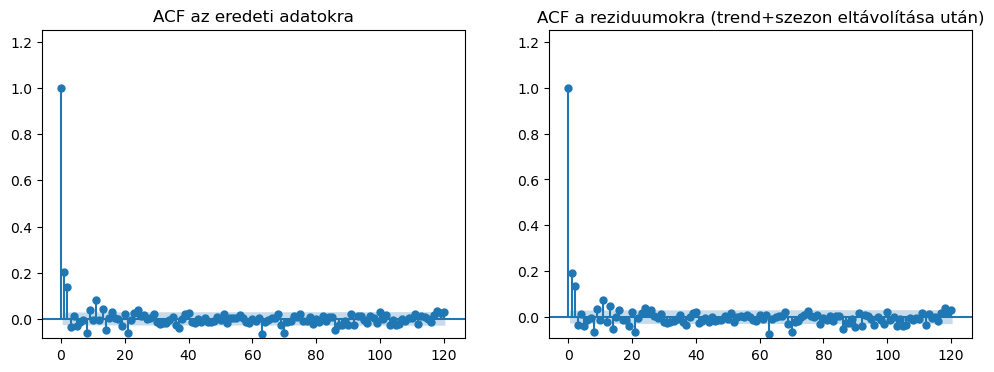

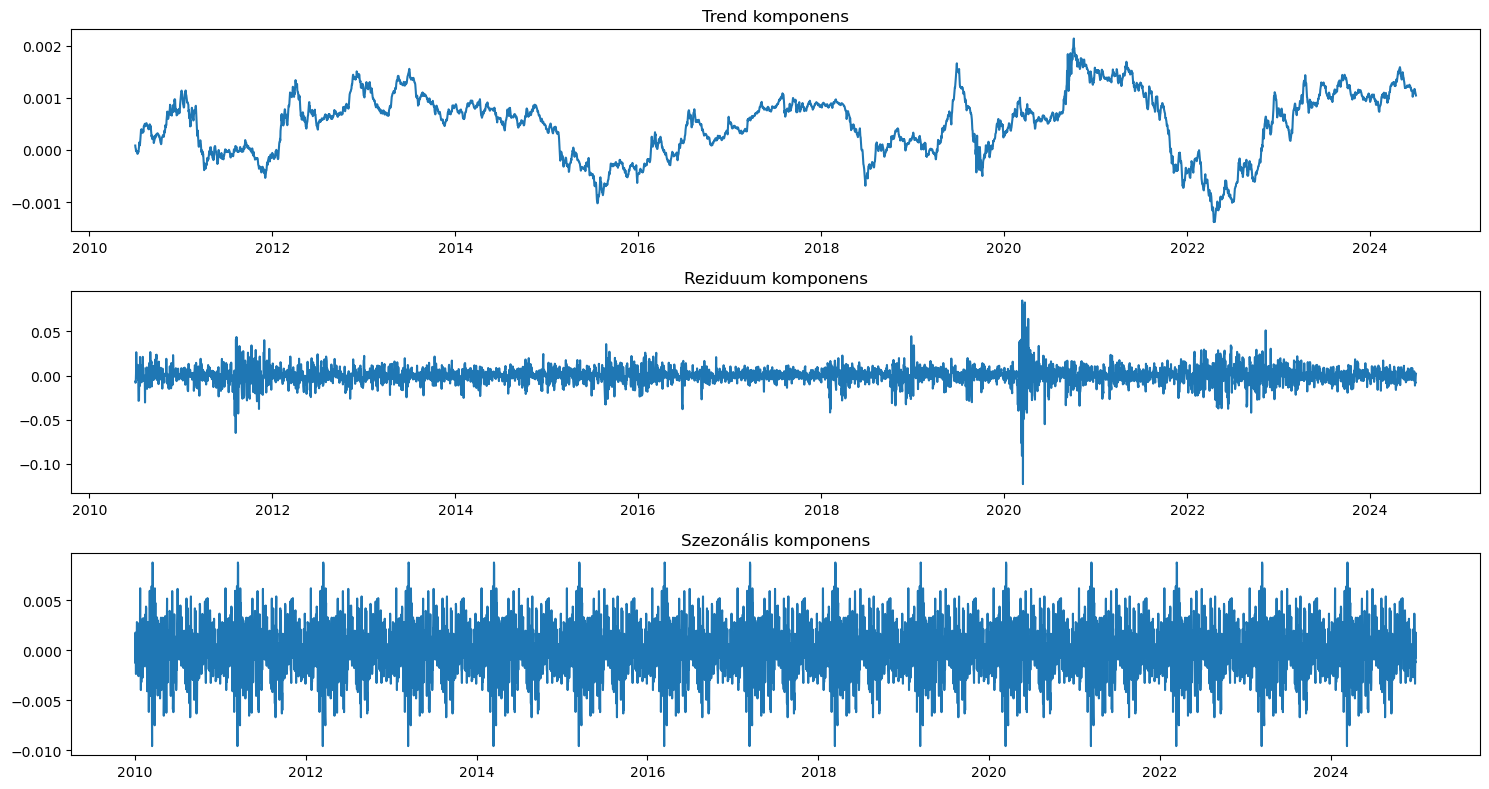

In [25]:
res = sm.tsa.seasonal_decompose(log_returns, period=365)
residual = res.resid[np.isfinite(res.resid)]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))
tsaplots.plot_acf(log_returns, lags=120, ax=ax1, auto_ylims=True)
tsaplots.plot_acf(residual, lags=120, ax=ax2, auto_ylims=True)
ax1.set_title("ACF az eredeti adatokra")
ax2.set_title("ACF a reziduumokra (trend+szezon eltávolítása után)")
plt.show()

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
ax1.plot(res.trend)
ax1.set_title("Trend komponens")
ax2.plot(res.resid)
ax2.set_title("Reziduum komponens")
ax3.plot(res.seasonal)
ax3.set_title("Szezonális komponens")
plt.tight_layout()
plt.show()

### 1.2.2 Statistical Time Series Analysis  
According to the ACF test, the series is strongly autocorrelated.

PACF:  
The first lag is high, and the 2nd and 3rd are somewhat higher than the rest, while the following lags are no longer significant. Based on this, direct effects are only significant for the first two lags.

[ 1.          0.20316299  0.13664993 -0.03487231  0.01319257 -0.02910759
 -0.01265566 -0.00580142 -0.05981136  0.03645059 -0.00268769  0.08164504
 -0.00591806  0.04376488 -0.049003    0.00203765  0.03113131  0.00459479
 -0.00162787 -0.02872558  0.02211882 -0.06047078 -0.00432018  0.02385874
  0.0391314   0.01391809  0.01691236  0.00140754  0.0052512   0.02327239
 -0.01328035 -0.02174525 -0.01701408 -0.01872937 -0.00395231  0.00666708
 -0.02834361 -0.03858889]


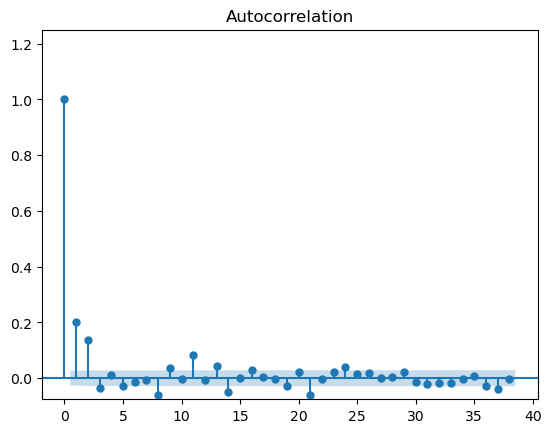

In [28]:
print(acf(log_returns))
plot_acf(log_returns, auto_ylims=True);

[ 1.          0.20320009  0.09951872 -0.08441365  0.02261859 -0.02147682
 -0.01145989  0.00739537 -0.06452231  0.06301385 -0.00661828  0.06711922
 -0.02673721  0.02796139 -0.05116192  0.00948867  0.04929788 -0.01527623
 -0.00920731 -0.01476304  0.02274344 -0.05922302 -0.00460268  0.05553644
  0.01515714  0.00223072  0.00519399 -0.00781186  0.01031739  0.01302558
 -0.01131018 -0.02234397  0.00608762 -0.02132071  0.0084456   0.0020458
 -0.04267365 -0.02007467]


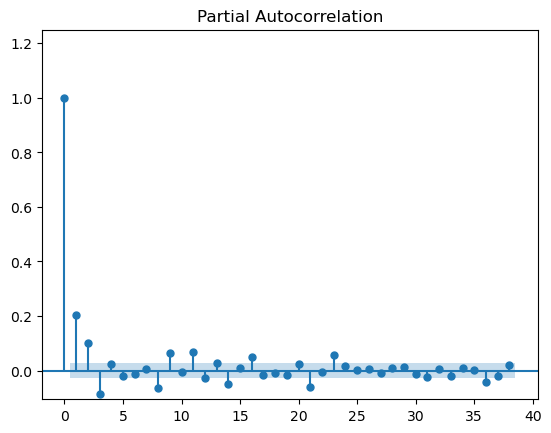

In [29]:
print(pacf(log_returns))
plot_pacf(log_returns, auto_ylims=True);

#### Stationarity Test:
- **ADF test result: -14.848024:**
    - p-value: 0.000000
    - Critical Values
        - 1%: -3.42
        - 5%: -2.62
        - 10%:

- **KPSS test result**:
    - Test Statistic           0.093986
    - p-value                  0.100000
    - Lags Used                8.000000
    - Critical Value (10%)     0.347000
    - Critical Value (5%)      0.463000
    - Critical Value (2.5%)    0.574000
    - Critical Value (1%)      0.739000

    Both the ADF and KPSS tests indicate that the S&P 500 log returns are stationary, and differencing is not necessary.

#### Examination of Autocorrelations:
- Based on the autocorrelation (ACF) and partial autocorrelation (PACF) plots:
  - **The autocorrelation of log returns is low**, it drops quickly, showing no strong linear dependence.
  - However, the autocorrelations of the squared and absolute log returns are higher, indicating **volatility dependence**. This is one of 

In [31]:
#ADF test
print(ADFTest().is_stationary(log_returns))

result = adfuller(log_returns, autolag='t-stat')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

(0.01, False)
ADF Statistic: -14.822133
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


C:\Users\Dell\AppData\Local\Temp\ipykernel_16168\2417806011.py:2: DeprecationWarning: is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.
  print(ADFTest().is_stationary(log_returns))


In [32]:
#KPSS teszt

print(KPSSTest().is_stationary(log_returns))

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

kpss_test(log_returns)

(0.1, False)
Results of KPSS Test:
Test Statistic           0.079079
p-value                  0.100000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\Dell\AppData\Local\Temp\ipykernel_16168\579852434.py:3: DeprecationWarning: is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.
  print(KPSSTest().is_stationary(log_returns))
C:\Users\Dell\AppData\Local\Temp\ipykernel_16168\579852434.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")


(-14.822132690514556, 1.9563452484591595e-27, 22, 5455, {'1%': -3.431549336360456, '5%': -2.862069986712047, '10%': -2.5670521108965025}, -34406.05742338998)
(-14.822132690514556, 1.9563452484591595e-27, 22, 5455, {'1%': -3.431549336360456, '5%': -2.862069986712047, '10%': -2.5670521108965025}, -34406.05742338998)


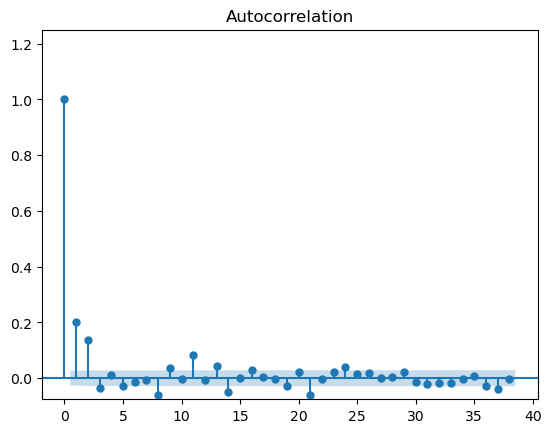

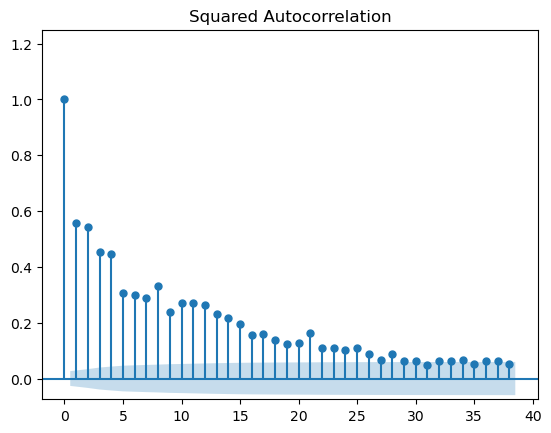

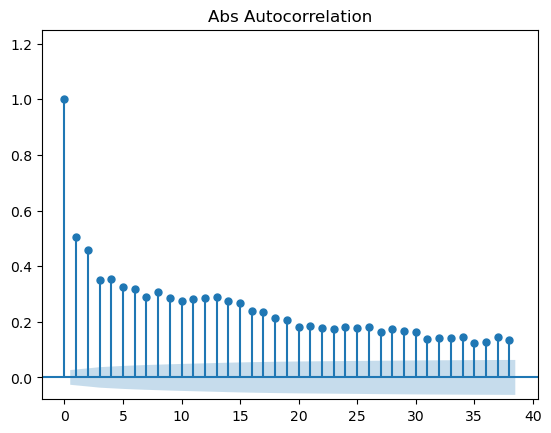

In [33]:
#plot autocorrelations
plot_acf(log_returns, auto_ylims=True);
plot_acf(np.power(log_returns, 2), auto_ylims=True,label ='asd');
plt.title('Squared Autocorrelation')
plot_acf(np.abs(data['spx_log_returns']), auto_ylims=True);
plt.title('Abs Autocorrelation')

print(adfuller(log_returns))
print(adfuller(log_returns))

#### According to the autocorrelation and partial autocorrelation function of the first difference of the term spread time series, 

In the case of the ADF test, we reject the null hypothesis that the time series is non-stationary, while the KPSS test leads us to accept the null hypothesis that the time series is stationary.

### Fitting ARMA(0,0,5) model to log returns

---

### Model Results:
- **AIC**: -34493.969
- **BIC**: -34457.592
- **HQIC**: -34483.410
- **Log Likelihood**: 17254.621
- All AR and MA components are **significant** (p-values 0.000), so the model parameters are reliable.
- The constant term (**intercept**) is also significant at the 5% confidence interval (p-value: 0.013)

---

### Diagnostic Tests:
- **Ljung-Box test (p=0.99)**: no residual autocorrelation, meaning the model fits well.
- **Jarque-Bera test (p=0.00)**: residuals are not normally distributed, indicating a deviation in the distribution.
- **Heteroscedasticity test (p=0.00)**: heteroscedasticity is still present.
- **Skewness**: -0.32 (mild asymmetry).
- **Kurtosis**: 20.82, indicating a more pronounced peak.

---

### Conclusion:
- The **ARMA(2,0,2)** model effectively describes the structure of the S&P 500 log returns.
- There is no residual autocorrelation, showing that the linear dependencies of the time series have been captured.
- However, the residuals are not normally distributed and contain heteroscedasticity.
- This confirms that **fitting GARCH models as a next step is necessary to model volatility** and handle the variable variance.









In [37]:
arima_model = auto_arima((data["spx_log_returns"]), seasonal = False,  stepwise=False, suppress_warnings=True, max_p=5,  trace=True)


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-34166.832, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-34351.033, Time=0.71 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-34481.548, Time=0.24 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-34486.236, Time=0.91 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-34489.156, Time=1.04 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=-34493.969, Time=0.62 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-34399.609, Time=0.38 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-34427.899, Time=0.54 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-34490.156, Time=0.45 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-34489.341, Time=1.05 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-34481.884, Time=0.99 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-34453.576, Time=0.46 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-34485.890, Time=1.81 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-34492.106, Time=0.61 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-34487

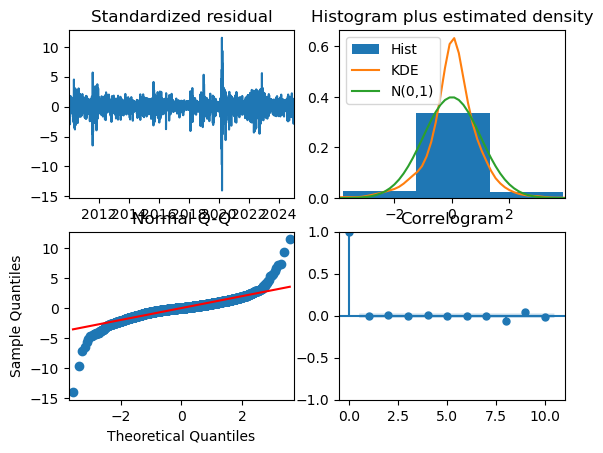

In [38]:
arima_model.plot_diagnostics();

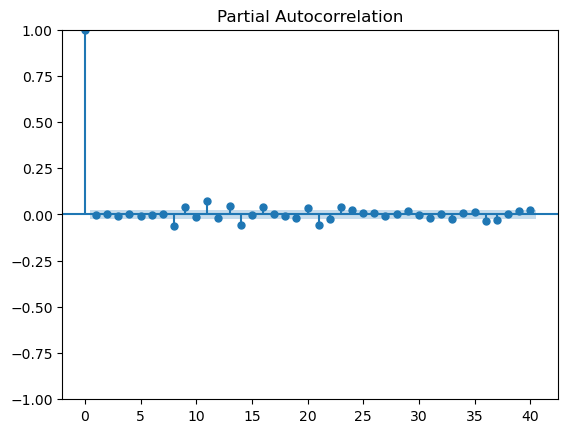

In [39]:
# Ensure residuals are properly extracted
a_res = arima_model.resid()  # or arima_model.resid()

# Plot ACF of residuals
plot_pacf(a_res, lags=40)
plt.show()

In [40]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5478
Model:               SARIMAX(0, 0, 5)   Log Likelihood               17252.984
Date:                Mon, 24 Mar 2025   AIC                         -34493.969
Time:                        02:37:15   BIC                         -34454.318
Sample:                    01-02-2010   HQIC                        -34480.136
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1992      0.005     41.562      0.000       0.190       0.209
ma.L2          0.1450      0.006     24.732      0.000       0.134       0.157
ma.L3         -0.0301      0.005     -5.530      0.000      -0.041      -0.019
ma.L4          0.0204      0.006      3.681      0.000       0.010       0.031
ma.L5         -0.0263      0.006     -4.283      0.000      -0.038      -0.014
sigma2         0.0001   8.76e-07    122.875      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):             73313.99
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 1.2.3 GARCH Model Interpretation:

### Model:
- **GARCH(1,4)** model was fitted to the S&P 500 log returns.
- **Mean model**: Zero Mean (the ARMA model has already filtered out the structure of the returns, so we focus only on the volatility).
- **Distribution**: Standardized Student’s t-distribution (suitable for better modeling extreme fluctuations).
- **Log-likelihood**:  18794.8
- **AIC**: -37577.6
---
- **TGARCH(1,2,4)**
- **AIC**: -35500.9
---
- **APARCH(1,4,1)**
- **AIC**: -37145
---
- **EGARCH(1,4)**
- **AIC**: -37231.8

### GARCH Parameters:
- **omega (ω)** =  2.1512e-06 → the baseline volatility level, quite low
- **alpha (α)** = 0.20 → the role of the previous day's return squared (shock effect).
- **beta (β)** = 0.26 → the effect of past volatility, which is considered strong
- **nu** = 6.26 → the degrees of freedom of the Student’s t-distribution, indicating moderately fat tails

All parameters are significant (p-values ≈ 0.000), indicating that the model is stable and reliable.

---

### Diagnostic Plots:
- **Standardized Residuals**: the residual variance fluctuates around zero, no strong patterns, but occasional spikes occur.
- **Conditional Volatility**: it is clear that volatility changes over time, with peak periods (e.g., during crises or market stress), followed by calming periods.

In [42]:

# ARIMA modell maradékainak kinyerése
residuals = arima_model.arima_res_.resid


#grid search best garch parameters
best_aic = np.inf
best_p, best_q = None, None
for p in range(1, 6):
    for q in range(1, 6):
        model = arch_model(residuals, vol='Garch', p=p, q=q)
        results = model.fit(disp="off")
        
        # Compare the AIC of the models
        if results.aic < best_aic:
            best_aic = results.aic
            best_p, best_q = p, q

print(f"Best p: {best_p}, Best q: {best_q}")

C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001075. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001075. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataSca

Best p: 1, Best q: 4


C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001075. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001075. Parameter
estimation work better when this value is between 1 and 1000. The r

In [43]:

# GARCH modell illesztése az ARIMA modell maradékaira
# Megjegyzés: A (p,q) paramétereket itt is az adatsor alapján kell meghatározni. Példaként (1,1)-et használunk.
garch_model = arch_model(residuals, vol='Garch', p=best_p, q=best_q, mean='Zero', dist='StudentsT')
garch_result = garch_model.fit(disp='off')

# Eredmények kiíratása
print(garch_result.summary())



C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001075. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                18788.2
Distribution:      Standardized Student's t   AIC:                          -37562.4
Method:                  Maximum Likelihood   BIC:                          -37516.1
                                              No. Observations:                 5478
Date:                      Mon, Mar 24 2025   Df Residuals:                     5478
Time:                              02:37:17   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omeg

In [44]:
#find best o parameter for TGARCH

best_aic = float('inf')
best_o = None

for o in range(1, 6):  # Try different values of o
    tgarch_model = arch_model(residuals, vol='Garch', p=best_p, o=o, q=best_q)
    tgarch_fit = tgarch_model.fit(disp='off')
    aic = tgarch_fit.aic
    if aic < best_aic:
        best_aic = aic
        best_o = o

print(f"Best order for o based on AIC: {best_o}")


best_aic = float('inf')
best_power = None

#find best power hyperparam for APARCH
for power in [1, 1.5, 2, 2.5, 3]:
    aparch_model = arch_model(residuals, vol='APARCH', p=best_p, q=best_q, power=power)
    aparch_fit = aparch_model.fit(disp='off')
    aic = aparch_fit.aic
    if aic < best_aic:
        best_aic = aic
        best_power = power
        
print(f"Best order for power based on AIC: {best_power}")

C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001075. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001075. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataSca

Best order for o based on AIC: 2


C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001075. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001075. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataSca

Best order for power based on AIC: 1


C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001075. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001075. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataSca

TGARCH Model Summary:
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                18678.1
Distribution:                  Normal   AIC:                          -37338.1
Method:            Maximum Likelihood   BIC:                          -37278.6
                                        No. Observations:                 5478
Date:                Mon, Mar 24 2025   Df Residuals:                     5477
Time:                        02:37:19   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         5.0753e-04  1.105e-03 

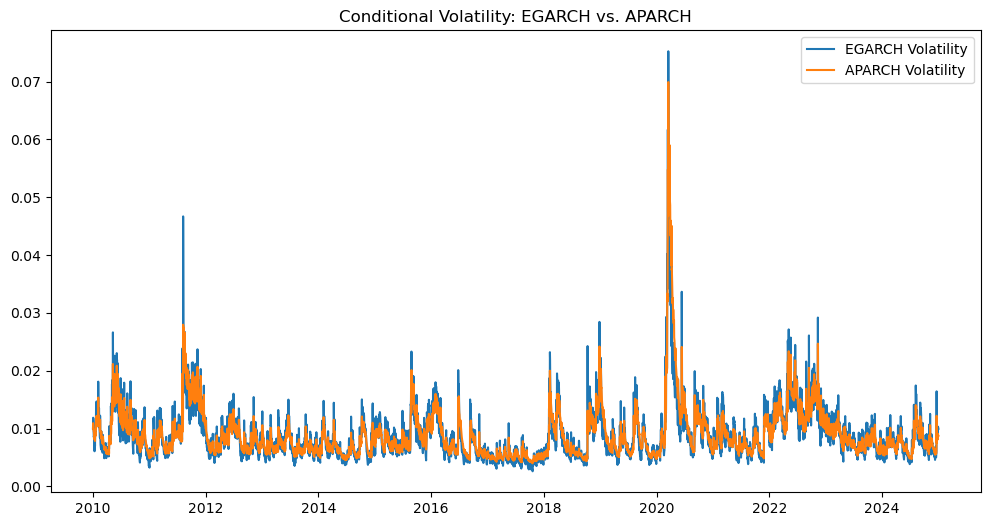

In [45]:
# Fit EGARCH model
egarch_model = arch_model(residuals, vol='EGARCH', p=best_p, q=best_q)  # p and q are the order of the lags
egarch_fit = egarch_model.fit(disp='off')

# Fit APARCH model
aparch_model = arch_model(residuals, vol='APARCH', p=best_p, q=best_q, power=best_power)  # You can vary the power
aparch_fit = aparch_model.fit(disp='off')

tgarch_model = arch_model(residuals, vol='Garch', p=best_p, o=best_o, q=best_q)  # p, o, q are the orders for GARCH, TGARCH model
tgarch_fit = tgarch_model.fit(disp='off')

# Print model summary
print("TGARCH Model Summary:")
print(tgarch_fit.summary())

print("EGARCH Model Summary:")
print(egarch_fit.summary())

print("\nAPARCH Model Summary:")
print(aparch_fit.summary())

# Plot volatility
plt.figure(figsize=(12, 6))
plt.plot(egarch_fit.conditional_volatility, label="EGARCH Volatility")
plt.plot(aparch_fit.conditional_volatility, label="APARCH Volatility")
plt.legend()
plt.title("Conditional Volatility: EGARCH vs. APARCH")
plt.show()

### GARCH Post-Validation

Based on the Ljung-Box test, the null hypothesis can be rejected in several cases, indicating that autocorrelation is still present in the series.

The autocorrelation of the residuals significantly decreases after the first lag.

The Q-Q plot shows that the residuals do not fit the normal distribution properly, with a significant deviation at the tail ends.

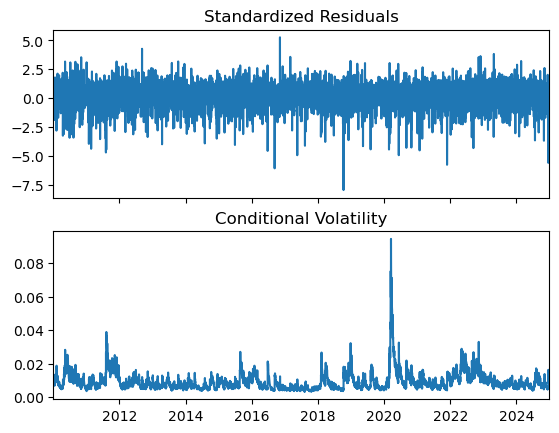

In [47]:
# A GARCH modell diagnosztikai ábráinak megjelenítése
garch_result.plot();

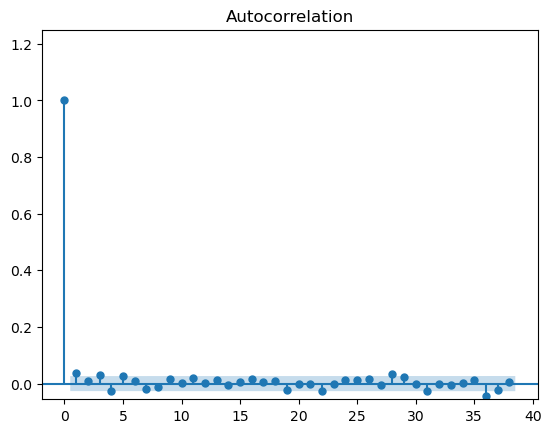

In [48]:
std_resid = garch_result.resid / garch_result.conditional_volatility
plot_acf(std_resid, auto_ylims=True);

In [49]:
lb_test = acorr_ljungbox(std_resid)
print('P-values are: ', lb_test)

P-values are:        lb_stat  lb_pvalue
1    8.255890   0.004062
2    8.783535   0.012379
3   13.625913   0.003461
4   17.277738   0.001707
5   21.030379   0.000799
6   21.446257   0.001525
7   23.593252   0.001343
8   24.616582   0.001805
9   26.126684   0.001948
10  26.134874   0.003563


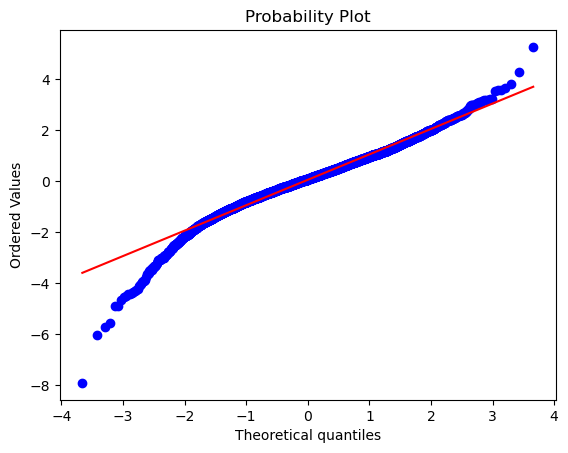

In [50]:
stats.probplot(std_resid, plot=plt)
plt.show();

In [ ]:
Nem sikerült megszüntetni az eltérést

### 1.2.4 Forecasts with ARIMA and GARCH Models

**The forecasts from both the ARIMA and GARCH models significantly deviated from the actual values.**

 - ARIMA RMSE: 0.00863060109086361
 - ARIMA MAE: 0.006257343981983402
 - ARIMA R-squared: 0.0020202480060063

The ARIMA model does not capture the variance well in the time series, as indicated by the weak R-squared. Otherwise, the errors are not large, but it struggles with volatility.

 - GARCH RMSE (Volatility): 0.001770
 - GARCH MAE (Volatility): 0.00171

The GARCH model does not show significant fluctuations, even though heteroscedasticity would justify it. Instead, it appears relatively linear.9

In [52]:
#train_test_split
test_size = 31


train = data[:-test_size]

# Last 30 days for testing
test = data[-test_size:]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-34290.328, Time=1.90 sec
First viable model found (-34290.328)
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-33972.850, Time=0.71 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-34198.253, Time=0.95 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-34151.502, Time=1.56 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-33972.850, Time=0.78 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-34288.671, Time=1.86 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-34282.768, Time=5.00 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-34286.702, Time=2.63 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-34285.533, Time=1.86 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-34225.065, Time=2.39 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-34287.415, Time=1.34 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-34287.670, Time=4.11 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-34286.440, Time=8.77 sec
 ARIMA(2,0,2)(0,0,0)[0]            

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


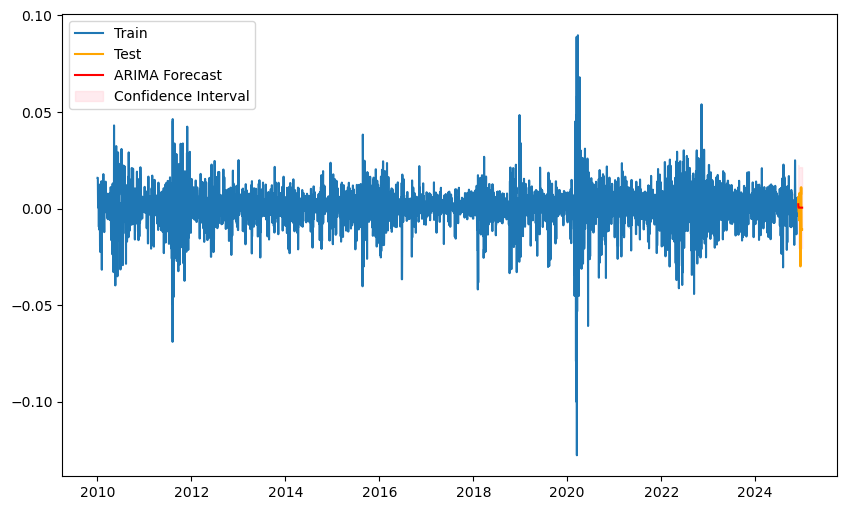

ARIMA RMSE: 0.00882300146924758
ARIMA MAE: 0.006467101600951339
ARIMA R-squared: -0.0021945414340325264


In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

arima_model_train = auto_arima((train["spx_log_returns"]), trend='c',  stepwise=True, suppress_warnings=True, max_p=6, trace=2)
# Forecasting
forecast_steps = len(test)
forecast_values, conf_int = arima_model_train.predict(n_periods=forecast_steps, return_conf_int=True)

# Evaluate forecast performance
rmse = mean_squared_error(test['spx_log_returns'], forecast_values, squared=False)
mae = mean_absolute_error(test['spx_log_returns'], forecast_values)
r2 = r2_score(test['spx_log_returns'], forecast_values)


# Visualization
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['spx_log_returns'], label='Train')
plt.plot(test.index, test['spx_log_returns'], label='Test', color='orange')
plt.plot(test.index, forecast_values, label='ARIMA Forecast', color='red')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.show()

# Print evaluation metrics
print(f'ARIMA RMSE: {rmse}')
print(f'ARIMA MAE: {mae}')
print(f'ARIMA R-squared: {r2}')

In [54]:
train_residuals = arima_model_train.arima_res_.resid

GARCH RMSE (Volatility): 0.001904
GARCH MAE (Volatility): 0.001868


C:\Users\Dell\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001078. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


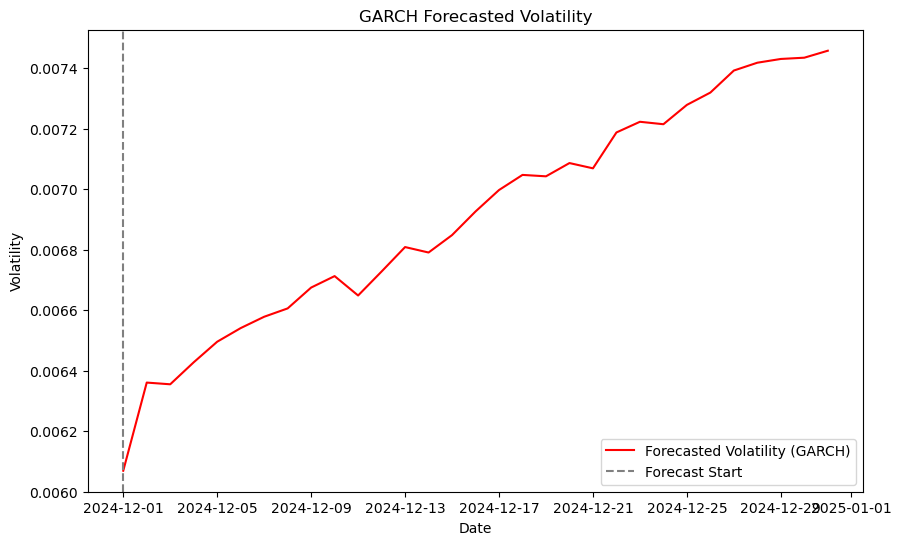

In [55]:
# fit garch on train
garch_model = arch_model(train_residuals, vol='Garch', p=best_p, q=best_q)
garch_fit = garch_model.fit(disp="off")

#forecast
garch_forecast = garch_fit.forecast(start=train_residuals.index[-1], horizon=len(test),method ='simulation', reindex=False)

# Extract forecasted volatility (square root of variance)
forecasted_volatility = np.sqrt(garch_forecast.variance.values[-1, :])

#residuals
test_residuals = test["spx_log_returns"] - forecast_values  # Actual - ARIMA forecast
actual_volatility = np.sqrt(np.var(test_residuals))  # Actual volatility

#metrics
rmse_volatility = mean_squared_error(np.repeat(actual_volatility, len(test)), forecasted_volatility, squared=False)
mae_volatility = mean_absolute_error(np.repeat(actual_volatility, len(test)), forecasted_volatility)

#Print metrics
print(f'GARCH RMSE (Volatility): {rmse_volatility:.6f}')
print(f'GARCH MAE (Volatility): {mae_volatility:.6f}')

# Plot residuals and volatility
plt.figure(figsize=(10, 6))
plt.plot(test.index, forecasted_volatility, label='Forecasted Volatility (GARCH)', color='red')
#plt.plot(test.index, np.abs(test_residuals), label='Actual Residuals', color='blue', alpha=0.5)
plt.axvline(x=test.index[0], color='gray', linestyle='--', label='Forecast Start')
plt.title("GARCH Forecasted Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [56]:
forecast_values

2024-12-01    0.002241
2024-12-02    0.000832
2024-12-03    0.000504
2024-12-04    0.000506
2024-12-05    0.000479
2024-12-06    0.000489
2024-12-07    0.000483
2024-12-08    0.000486
2024-12-09    0.000484
2024-12-10    0.000485
2024-12-11    0.000485
2024-12-12    0.000485
2024-12-13    0.000485
2024-12-14    0.000485
2024-12-15    0.000485
2024-12-16    0.000485
2024-12-17    0.000485
2024-12-18    0.000485
2024-12-19    0.000485
2024-12-20    0.000485
2024-12-21    0.000485
2024-12-22    0.000485
2024-12-23    0.000485
2024-12-24    0.000485
2024-12-25    0.000485
2024-12-26    0.000485
2024-12-27    0.000485
2024-12-28    0.000485
2024-12-29    0.000485
2024-12-30    0.000485
2024-12-31    0.000485
Freq: D, dtype: float64

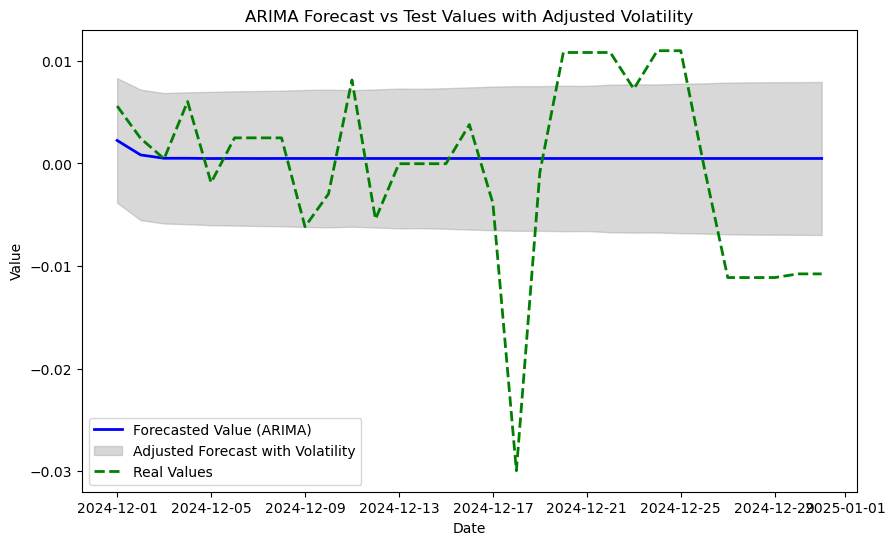

In [57]:
real_test_values = test['spx_log_returns']

# Adjusting forecast by adding and subtracting volatility
adjusted_upper_bound = forecast_values + forecasted_volatility.flatten()
adjusted_lower_bound = forecast_values - forecasted_volatility.flatten()

# Plotting the forecast and adjusted bounds
plt.figure(figsize=(10, 6))

# Plot the forecasted values (ARIMA forecast)
plt.plot(forecast_values.index, forecast_values, label='Forecasted Value (ARIMA)', color='blue', linewidth=2)

# Plot the adjusted confidence intervals
plt.fill_between(forecast_values.index, adjusted_lower_bound, adjusted_upper_bound, color='gray', alpha=0.3, label='Adjusted Forecast with Volatility')

# Plot the real test values (actual observed values)
plt.plot(forecast_values.index, real_test_values, label='Real Values', color='green', linestyle='--', linewidth=2)

# Labels and title
plt.title('ARIMA Forecast vs Test Values with Adjusted Volatility')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()